# Parameter Tuning Welch

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne import io
from mne.time_frequency import psd_welch

from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.plts.spectra import plot_spectrum
#%matplotlib qt

#### Create MNE Info

In [2]:
ch_names = ['SMA', 'leftM1', 'rightM1', 'STN_R01', 'STN_R12', 'STN_R23', 'STN_L01', 'STN_L12', 'STN_L23', 'EMG_R', 'EMG_L', 'HEOG', 'VEOG', 'event']
sfreq = 2400
ch_types = ["mag", "mag", "mag", "seeg", "seeg", "seeg", "seeg", "seeg", "seeg", "emg", "emg", "eog", "eog", "misc"]
info = mne.create_info(ch_names, sfreq, ch_types, verbose=True)

#### Load all subjects

In [3]:
%%capture
cond = "on"
raw_on = []

for i in range(1, 15):
    path = f'../../data/raw/rest/subj{i}/{cond}/'
    fname = os.listdir(path)[0]  # load first file only 
    raw_on.append(mne.io.read_raw_fieldtrip(path + fname, info, data_name='data'))

cond = "off"
raw_off = []

for i in range(1, 15):
    path = f'../../data/raw/rest/subj{i}/{cond}/'
    fname = os.listdir(path)[0]  # load first file only 
    raw_off.append(mne.io.read_raw_fieldtrip(path + fname, info, data_name='data'))

#### AC Notch Filter

In [4]:
#### Filter Parameters
filter_freqs = np.arange(50, 101, 50) # only 50Hz and 100Hz
notch_widths = .01 # gives best result
filter_window = "hann" # gives slightly better results than hamming

filter_params = {"freqs": filter_freqs, "notch_widths": notch_widths, "method": "fir", "filter_length": "auto",  "trans_bandwidth": 1,  "phase": "zero", "fir_window": filter_window, "fir_design": "firwin"}
filter_params = {"freqs": filter_freqs, "notch_widths": notch_widths, "fir_window": filter_window} # rest is default

In [5]:
%%capture
filtered_on = []
filtered_off = []

for raw in raw_on:
    filt = raw.copy().notch_filter(**filter_params)
    filtered_on.append(filt)

for raw in raw_off:
    filt = raw.copy().notch_filter(**filter_params)
    filtered_off.append(filt)

#### Compute Power Spectra using Welch's Method

In [92]:
#### Welch Parameters
n_per_seg1 = 1 * sfreq
n_per_seg2 = int(0.5 * sfreq)
fmin = 20 # we want spectrum from 20 Hz on
fmax = 99 # we want spectrum up to 100 Hz. 100 Hz excluded due to AC artefact
n_overlap = 0 # previously n_per_seg // 2 but makes no difference, defaults to 0
median = "median"
picks = "seeg"

welch_params1 = {"fmin": fmin, "fmax": fmax, "picks": picks, "n_overlap": n_overlap, "n_fft": n_per_seg, "n_per_seg": None, "average": median}
welch_params2 = {"fmin": fmin, "fmax": fmax, "picks": picks, "n_overlap": n_overlap, "n_fft": n_per_seg2, "n_per_seg": None, "average": median}

In [93]:
%%capture
spectra_filt_on1 = []
spectra_filt_off1 = []

for data in filtered_on:
    spec, freqs1 = psd_welch(data, **welch_params1)
    spectra_filt_on1.append(spec)

for data in filtered_off:
    spec, freqs1 = psd_welch(data, **welch_params1)
    spectra_filt_off1.append(spec)

In [94]:
%%capture
spectra_filt_on2 = []
spectra_filt_off2 = []

for data in filtered_on:
    spec, freqs2 = psd_welch(data, **welch_params2)
    spectra_filt_on2.append(spec)

for data in filtered_off:
    spec, freqs2 = psd_welch(data, **welch_params2)
    spectra_filt_off2.append(spec)

#### Visualize Power Spectrum and fooof

In [95]:
#### fooof Parameters
freq_range = [20, 95] # "The E/I ratio will be measured with the slope of the broadband LFP spectrum at 20-100 Hz"
peak_width_limits = (2, 10)
max_n_peaks = 4
# min_peak_height=0
peak_threshold=2
aperiodic_mode="knee"
verbose=True

fooof_params = {"peak_width_limits": peak_width_limits, "max_n_peaks": max_n_peaks, "peak_threshold": peak_threshold, "aperiodic_mode": aperiodic_mode, "verbose": verbose}

fm = FOOOF(**fooof_params)

In [96]:
num_subj = len(spectra_filt_on1)
num_el = len(spectra_filt_on1[0])

filt1 = spectra_filt_on1 + spectra_filt_off1
filt2 = spectra_filt_on2 + spectra_filt_off2

stn_names = ch_names[3:9]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 2.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 2.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 2.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a low

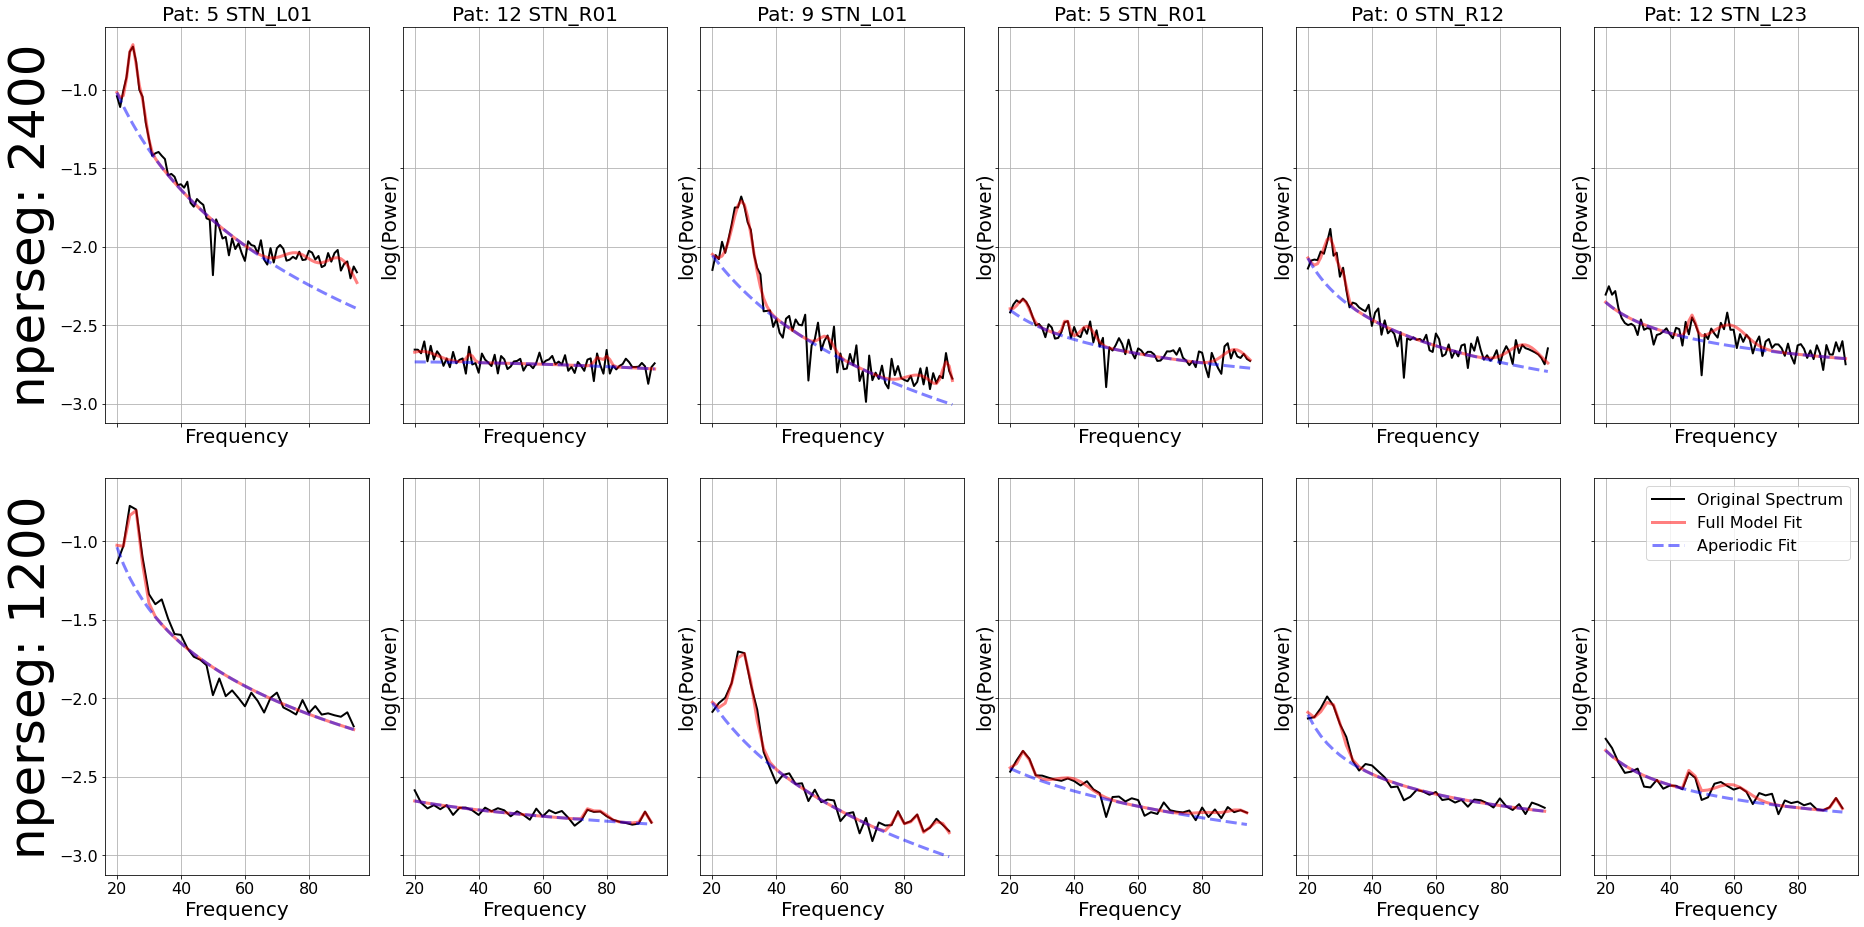

In [105]:
#### plot 6 random STN spectra before and 6 after filtering
np.random.seed(seed=1)

fig, ax = plt.subplots(2, 6, figsize=(26, 13), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(6):
    subj = np.random.randint(num_subj)
    el = np.random.randint(num_el)
    ax[i].set_title(f"Pat: {subj} {stn_names[el]}", fontsize=20)
    try:
        fm.fit(freqs1, filt1[subj][el], freq_range)
        fm.plot(ax=ax[i])
         #   fm.print_results()
        ax[i].get_legend().remove()
        
        fm.fit(freqs2, filt2[subj][el], freq_range)
        fm.plot(ax=ax[i+6])
    #    fm.print_results()
        if i < 5:
            ax[i+6].get_legend().remove()
    except IndexError:
        pass
ax[0].set_ylabel(f"nperseg: {welch_params1['n_fft']}", fontsize=50)
ax[6].set_ylabel(f"nperseg: {welch_params2['n_fft']}", fontsize=50)
plt.tight_layout()
plt.savefig("/Users/moritzgerster/Documents/Promotion/Research_Updates/welch.pdf")
plt.show()

###  "we will use Welch’s average periodogram technique over 1-s segments"

# However, 0.5s segments gives smoother spectra -> better for fooof!